Link to Medium blog post: https://medium.com/swlh/an-introduction-to-categorical-feature-encoding-in-machine-learning-cd0ca08c8232

# Hands-on Categorical Feature Encoding in Machine Learning

## Load the required libraries


In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd 
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from category_encoders.target_encoder import TargetEncoder
from category_encoders.leave_one_out import LeaveOneOutEncoder
from category_encoders.m_estimate import MEstimateEncoder

pd.set_option('max.rows',400)
pd.set_option('max.columns',80)

'''Load the data'''
train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')

'''Columns with more than 70% of missing values'''
drop_cols = ['Alley', 'PoolQC', 'Fence', 'MiscFeature']
train.drop(drop_cols, axis = 1, inplace =True)

'''Segregate the categoric columns'''
categoric_cols = train.select_dtypes('object').columns
train_categoric = train[categoric_cols]

'''Segregate ordinal and nominal columns'''
nominal_cols = ['MSZoning', 'Street','LandContour','Neighborhood','Condition1','Condition2',
                'RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','Foundation',
                'Heating','GarageType','SaleType','SaleCondition']
ordinal_cols = ['ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1',
                'BsmtFinType2','HeatingQC','CentralAir','Electrical','KitchenQual','Functional',
                'FireplaceQu','GarageFinish','GarageQual','GarageCond','PavedDrive','LotShape',
                'Utilities','LandSlope','BldgType','HouseStyle','LotConfig']

"""Impute the features before encoding it."""
def mode_imputation(train_categoric):
    """
    Mode imputation of categoric columns
    """
    for col in train_categoric.columns:
        mode = train_categoric[col].mode().iloc[0]
        train_categoric[col] = train_categoric[col].fillna(mode)
    return train_categoric

train_categoric = mode_imputation(train_categoric)

# Ordinal Encoding

## 1. Ordinal Encoding using OrdinalEncoder in sci-kit learn

OrdinalEncoder is used to assign numerical values to the categories in the ordinal features.

In [ ]:
'''Segregate the ordinal columns'''
train_ordinal = train_categoric[ordinal_cols]
def ordinal_encode(train_ordinal):
    """
    Ordinal encoding of the categorical features
    """
    ord_enc = OrdinalEncoder(dtype=int)
    enc_freq = ord_enc.fit_transform(train_ordinal)
    train_ordinal_encoded = pd.DataFrame(enc_freq, columns= train_ordinal.columns, index =train_ordinal.index)
    return train_ordinal_encoded

train_ordinal_encoded = ordinal_encode(train_ordinal)

## 2. Ordinal Encoding using LabelEncoder in sci-kit learn

LabelEncoder would also produce the same result produced by the OrdinalEncoder.

In [ ]:
def label_encode(train_ordinal):
    """
    Label encoding of the categorical features
    """
    '''Create a copy of train_ordinal'''
    train_label_encoded = train_ordinal.copy()
    lab_enc_dict = {}
    for col in train_label_encoded:
        lab_enc_dict[col] = LabelEncoder()
        train_label_encoded[col] = lab_enc_dict[col].fit_transform(train_ordinal[col])
    return train_label_encoded

train_label_encoded = label_encode(train_ordinal)

# Nominal Encoding

## 1. Frequency Encoding

In frequency encoding, each of the categories in the feature is replaced with the frequencies of categories.

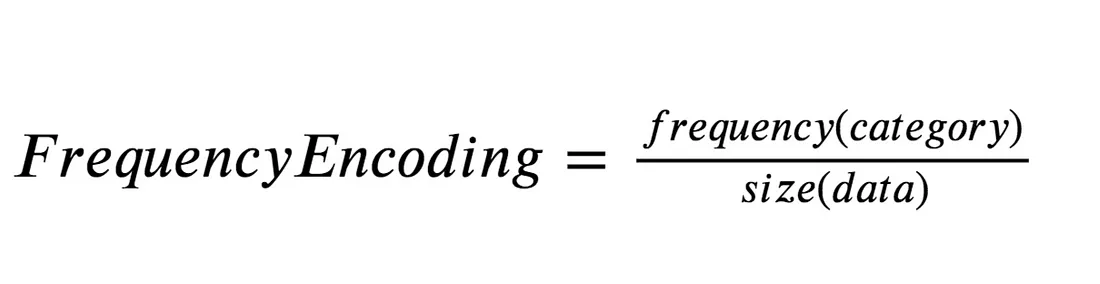

Category refers to each of the unique values in a feature.

- Frequency(category) = Number of values in that category

- Size(data) = Size of the entire dataset.

Disadvantage: If two categories have the same frequency then it is hard to distinguish between them.

In [ ]:
'''Segregate the nominal columns'''
train_nominal = pd.concat([train_categoric[nominal_cols], train['SalePrice']], axis = 1)
def frequency_encode(train_nominal):
    train_freq_encoded = pd.DataFrame()
    for col in train_nominal:
        if(col != 'SalePrice'):
            freq = train_nominal.groupby(col).size()/ len(train_nominal)
            train_freq_encoded[col] = train_nominal[col].map(freq)
    return train_freq_encoded

train_freq_encoded = frequency_encode(train_nominal)

## 2. Target Encoding

In target encoding, each of the categories is replaced with the mean of the target variable. Target encoding is one of the most used categorical encoding techniques in Kaggle.

- Target Encoding = mean(target of a category)

Disadvantage: Tends to overfit the data if some of the categories have a low number of occurrences.

In [ ]:
def target_encode_udf(train_nominal):
    """
    Target encoding (user defined function).
    """
    train_target_encoded = train_nominal.copy()
    for col in train_nominal:
        if(col != 'SalePrice'):
            mean = train_nominal.groupby(col)['SalePrice'].agg('mean')
            train_target_encoded[col] = train_nominal[col].map(mean)
    return train_target_encoded

train_target_encoded = target_encode_udf(train_nominal)

def target_encode_builtin(train_nominal):
    """
    Target encoding (using built-in class)
    """
    target_enc = TargetEncoder()
    x_train, y_train = train_nominal[train_nominal.columns[:-1]], train_nominal['SalePrice']
    train_target_encoded = target_enc.fit_transform(x_train, y_train)
    return train_target_encoded

train_target_encoded = target_encode_builtin(train_nominal)

## 3. One-Hot Encoding

One Hot Encoding replaces the categories with binary values. ‘N’ number of features is created if the unique values in a feature are equal to ‘N’.

Disadvantages:

- Tree algorithms cannot be applied to one-hot encoded data since it creates a sparse matrix.
- When the feature contains too many unique values, that many features are created which may result in overfitting.

In [ ]:
def onehot_encode(train_nominal):
    train_onehot_encoded = pd.get_dummies(train_nominal[train_nominal.columns[:-1]])
    return train_onehot_encoded
train_onehot_encoded = onehot_encode(train_nominal)

## 4. Leave One Out Encoding

Leave One Out Encoding(LOOE) is very similar to Target Encoding but the difference is LOOE doesn’t consider the current row while calculating the mean of the target.

Disadvantage: Tends to overfit to the data.

In [ ]:
def leave_oneout_encode(train_nominal):
    lo_enc = LeaveOneOutEncoder()
    x_train, y_train = train_nominal[train_nominal.columns[:-1]], train_nominal['SalePrice']
    train_lo_encoded = lo_enc.fit_transform(x_train, y_train)
    return train_lo_encoded

train_lo_encoded = leave_oneout_encode(train_nominal)

## 5. M-Estimate Encoding

M-Estimate Encoding is also called as additive smoothing overcomes the disadvantages of the Target Encoding (overfitting) by considering a smoothing factor M to encode.

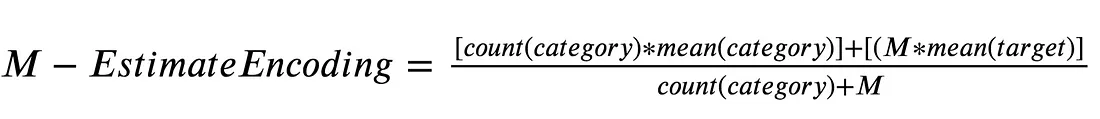

In [ ]:
def m_estimate_udf(train_nominal,col, M=100):    
    """
    M-Estimate encoding (User defined function)
    """
    agg_result = train_nominal.groupby(col).agg(['count','mean'])['SalePrice']
    category_counts = agg_result['count']
    category_means = agg_result['mean']
    target_mean = train_nominal['SalePrice'].mean()
    m_est = ((category_counts * category_means) + (M * target_mean))/(category_counts + M)
    return train_nominal[col].map(m_est)

train_mest_encoded = train_nominal.copy()
for col in train_nominal:
    if(col != 'SalePrice'):
        train_mest_encoded[col] = m_estimate_udf(train_nominal,col, M=100)
        
def m_estimate_encode_builtin(train_nominal, M=100):
    """M-Estimate encoding (using built-in function)"""
    me = MEstimateEncoder(m=M)
    x_train, y_train = train_nominal[train_nominal.columns[:-1]], train_nominal['SalePrice']
    train_mest_encoded = me.fit_transform(x_train,y_train)
    return train_mest_encoded

train_mest_encoded = m_estimate_encode_builtin(train_nominal, 100)